## Project 1 report

### Name (SID): Shuang

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

If you work on [Google Colab](https://colab.research.google.com), you need to first install PyTorch each time you run the file. You can also upload file and load files from your google drive.
Besides, you can also select GPU as Hardware accelerator in Edit->Notebook settings. 

Remember to run some of the following blocks if you work on Google Colab. You can ignore this part if you are not using Google Colab.

In [ ]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
# upload files to Colab
from google.colab import files
files.upload()

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. You only need to change the codes in 1.2 and 1.6 for successfuly experiments.

### 1.1 prepare data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [1]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [3]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Your split codes comes here.
# You need to random select the 5000 validation images 
  
indices = list(range(len(trainset)))
validation_idx = np.random.choice(indices, size=5000, replace=False)

train_idx = list(set(indices) - set(validation_idx))
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
validation_sampler = torch.utils.data.sampler.SubsetRandomSampler(validation_idx)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                           sampler=train_sampler, 
                                           shuffle=False, num_workers=2)

valloader =torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=False, num_workers=2,
                                        sampler=validation_sampler)
# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.

### 1.3 Define a Baseline Convolution Neural Network

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 1.4 Define a Loss function and optimizer

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


NameError: name 'net' is not defined

### 1.5 Train the network

In [19]:
# create the array of result
train_loss = []
val_loss = [] 
val_acc = [] 
test_acc = []

In [20]:
def train_1(train_loss, val_loss, val_acc, test_acc):
    
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    for epoch in range(4):  # loop over the dataset multiple times
        train_running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            train_running_loss += loss.item()
        print('%d epoch, train_loss: %.3f' %(epoch + 1, train_running_loss / len(trainloader)))
        train_loss.append(train_running_loss/ len(trainloader))
        train_running_loss = 0.0
                
        val_running_loss = 0.0
        for i, data in enumerate(valloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward 
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # print statistics
            val_running_loss += loss.item()
        print('%d epoch, val_loss: %.3f' %(epoch + 1, val_running_loss / len(valloader)))
        val_loss.append(val_running_loss / len(valloader))
        val_running_loss = 0.0    
        
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 5000 validation images: %d %%' % (
            100 * val_correct / val_total))    
        val_acc.append(100 * val_correct / val_total)
        
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * test_correct / test_total))
        test_acc.append(100 * test_correct / test_total)
    print('Finished Training\n')

In [21]:
train_1(train_loss, val_loss, val_acc, test_acc)

1 epoch, train_loss: 1.940
1 epoch, val_loss: 1.632
Accuracy of the network on the 5000 validation images: 40 %
Accuracy of the network on the 10000 test images: 41 %
2 epoch, train_loss: 1.500
2 epoch, val_loss: 1.489
Accuracy of the network on the 5000 validation images: 46 %
Accuracy of the network on the 10000 test images: 47 %
3 epoch, train_loss: 1.353
3 epoch, val_loss: 1.350
Accuracy of the network on the 5000 validation images: 52 %
Accuracy of the network on the 10000 test images: 52 %
4 epoch, train_loss: 1.257
4 epoch, val_loss: 1.314
Accuracy of the network on the 5000 validation images: 53 %
Accuracy of the network on the 10000 test images: 53 %
Finished Training



### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model.

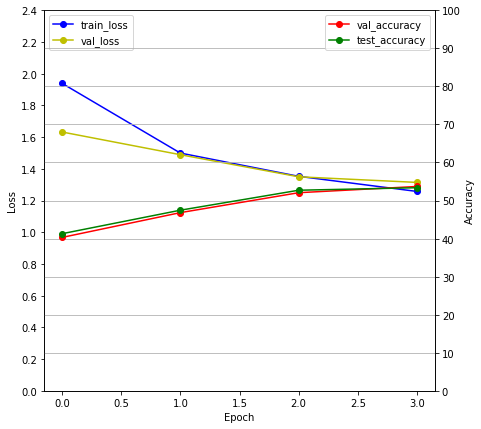

In [23]:
import matplotlib.pyplot as plt

plt.figure
plt.figure(figsize = (7, 7))
plt.subplot(1, 1, 1)

plt.plot(np.arange(len(train_loss)), train_loss, color = 'b', marker = 'o')
plt.plot(np.arange(len(val_loss)), val_loss, color = 'y', marker = 'o')


plt.yticks(np.arange(0, 2.5, 0.2))


plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.twinx()
plt.plot(np.arange(len(val_acc)), val_acc, color = 'r', marker = 'o')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'g', marker = 'o')
plt.yticks(np.arange(0, 110, 10))

plt.legend(['val_accuracy', 'test_accuracy'], loc='upper right')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

### 1.7 Eval the trained network

In [14]:
def eval_net(net, testloader, valloader):
    
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 5000 validation images: %d %%' % (
        100 * val_correct / val_total))    
    
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * test_correct / test_total))

eval_net(net, testloader, valloader)

Accuracy of the network on the 5000 validation images: 9 %
Accuracy of the network on the 10000 test images: 9 %


### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size: 8
2. Base learning rate: 0.001
3. Number of epochs: 8

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

(I do know that i only need to draw the loss or accuracy, but i draw both to get a more comprehensive analysis.)

As shown in the figures, learning rate 0.005, 0.00001 and 0.00005 perform really bad, especially 0.00001, completely fails in training the network. In additional, the performance of learning rate 0.0001 is unstable so I prefer to choose 0.001 or 0.0005 as learning rate.

Secondly, after epoch 1, 2 the network is far away from tuned fine. On average, over-fitting happens after epoch 6-7, so I guess 8 is a good choice, making the model achieve a balance between under-fitting and over-fitting.

Thirdly, compared each batch size, the set of dataset divided in batch size 8 gains a better result in general. I believe 8 is better for training.

In [ ]:
# Your codes comes here. 
# Please do not define the networks again, just make changes to the training procedure.
# There is no need to test the model trained for 2, 4, 8 epoches separately because number 16 covers 2, 4, 8.
# A set of figs shows the model trained by different learning rate but the same batch size.

In [84]:
# define the function for plot the information of the model
# This function plot 6 models in one figure. The epoch of each model is 16

def plot(train_loss, val_loss, val_acc, test_acc):
    plt.figure
    plt.figure(figsize = (15, 8))
    
    for i in range (6):   
        
        plt.subplot(2, 3, i + 1)

        plt.plot(np.arange(len(train_loss[i])), train_loss[i], color = 'b', marker = 'o')
        plt.plot(np.arange(len(val_loss[i])), val_loss[i], color = 'y', marker = 'o')

        plt.yticks(np.arange(0, 2.5, 0.2))

        plt.legend(['train_loss', 'val_loss'], loc='upper left')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

        plt.twinx()
        
        plt.plot(np.arange(len(val_acc[i])), val_acc[i], color = 'r', marker = 'o')
        plt.plot(np.arange(len(test_acc[i])), test_acc[i], color = 'g', marker = 'o')
        plt.yticks(np.arange(0, 110, 10))

        plt.legend(['val_accuracy', 'test_accuracy'], loc='upper right')
        plt.ylabel('Accuracy')
        plt.grid()
    plt.show()

In [27]:
# define the learning rate

learning_rate = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]

In [84]:
# there define a loop of 6 times, each loop only change the learning rate of the optimizer while the batch size is the same

def train_2(learning_rate, train_loss, val_loss, val_acc, test_acc):
    
    for k in range (len(learning_rate)):
        
        net = Net()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=learning_rate[k], momentum=0.9)
        print('learning_rate = %0.5f' %(learning_rate[k]))
        train_loss_s = []
        val_loss_s = []
        val_acc_s = []
        test_acc_s = []        
        
        for epoch in range(16):  # loop over the dataset multiple times

            train_running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs
                inputs, labels = data
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                train_running_loss += loss.item()
            print('%d epoch, train_loss: %.3f' %(epoch + 1, train_running_loss / len(trainloader)))
            train_loss_s.append(train_running_loss / len(trainloader))
            train_running_loss = 0.0

            val_running_loss = 0.0
            for i, data in enumerate(valloader, 0):
                # get the inputs
                inputs, labels = data
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward 
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                # print statistics
                val_running_loss += loss.item()
            print('%d epoch, val_loss: %.3f' %(epoch + 1, val_running_loss / len(valloader)))
            val_loss_s.append(val_running_loss / len(valloader))
            val_running_loss = 0.0    

            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 5000 validation images: %d %%' % (
                100 * val_correct / val_total))    
            val_acc_s.append(100 * val_correct / val_total)

            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * test_correct / test_total))
            test_acc_s.append(100 * test_correct / test_total)

        train_loss.append(train_loss_s)
        val_loss.append(val_loss_s)
        val_acc.append(val_acc_s)
        test_acc.append(test_acc_s)
        print('learning_rate = %0.5f, Finished Training\n' %(learning_rate[k]))

For bathc_size = 2

In [85]:
# allow a space to store the loss and accuracy of each epoch of each model

train_loss_2 = []
val_loss_2 = []
val_acc_2 = []
test_acc_2 = []

In [87]:
train_2(learning_rate, train_loss_2, val_loss_2, val_acc_2, test_acc_2)

learning_rate = 0.00500
1 epoch, train_loss: 2.103
1 epoch, val_loss: 2.256
Accuracy of the network on the 5000 validation images: 17 %
Accuracy of the network on the 10000 test images: 18 %
2 epoch, train_loss: 1.985
2 epoch, val_loss: 1.899
Accuracy of the network on the 5000 validation images: 28 %
Accuracy of the network on the 10000 test images: 28 %
3 epoch, train_loss: 1.980
3 epoch, val_loss: 2.030
Accuracy of the network on the 5000 validation images: 23 %
Accuracy of the network on the 10000 test images: 24 %
4 epoch, train_loss: 1.990
4 epoch, val_loss: 2.123
Accuracy of the network on the 5000 validation images: 25 %
Accuracy of the network on the 10000 test images: 25 %
5 epoch, train_loss: 1.995
5 epoch, val_loss: 2.005
Accuracy of the network on the 5000 validation images: 24 %
Accuracy of the network on the 10000 test images: 24 %
6 epoch, train_loss: 2.000
6 epoch, val_loss: 2.085
Accuracy of the network on the 5000 validation images: 22 %
Accuracy of the network on th

1 epoch, train_loss: 2.254
1 epoch, val_loss: 2.116
Accuracy of the network on the 5000 validation images: 21 %
Accuracy of the network on the 10000 test images: 20 %
2 epoch, train_loss: 2.012
2 epoch, val_loss: 1.887
Accuracy of the network on the 5000 validation images: 31 %
Accuracy of the network on the 10000 test images: 31 %
3 epoch, train_loss: 1.733
3 epoch, val_loss: 1.604
Accuracy of the network on the 5000 validation images: 41 %
Accuracy of the network on the 10000 test images: 41 %
4 epoch, train_loss: 1.560
4 epoch, val_loss: 1.534
Accuracy of the network on the 5000 validation images: 44 %
Accuracy of the network on the 10000 test images: 44 %
5 epoch, train_loss: 1.459
5 epoch, val_loss: 1.420
Accuracy of the network on the 5000 validation images: 48 %
Accuracy of the network on the 10000 test images: 49 %
6 epoch, train_loss: 1.391
6 epoch, val_loss: 1.358
Accuracy of the network on the 5000 validation images: 50 %
Accuracy of the network on the 10000 test images: 51 

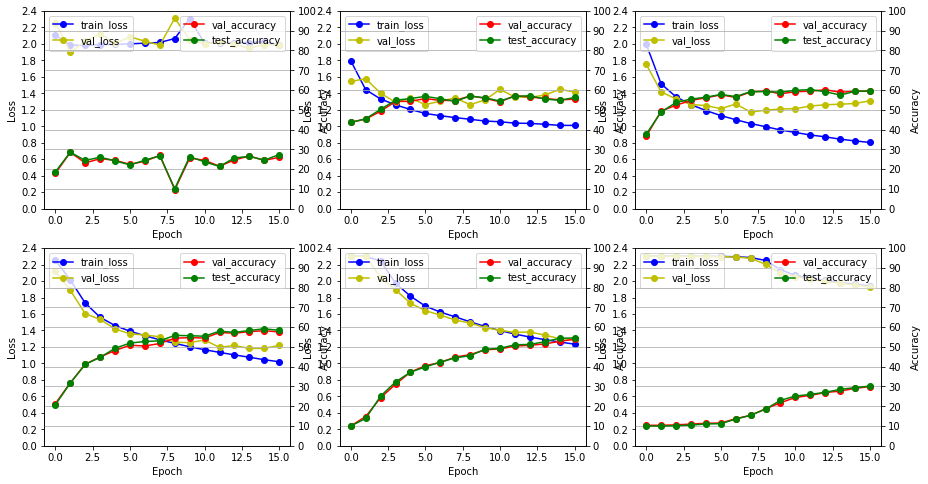

In [88]:
plot(train_loss_2, val_loss_2, val_acc_2, test_acc_2)

For bathc_size = 4

In [90]:
# allow a space to store the loss and accuracy of each epoch of each model

train_loss_4 = []
val_loss_4 = []
val_acc_4 = []
test_acc_4 = []

In [91]:
train_2(learning_rate, train_loss_4, val_loss_4, val_acc_4, test_acc_4)

learning_rate = 0.00500
1 epoch, train_loss: 1.881
1 epoch, val_loss: 1.725
Accuracy of the network on the 5000 validation images: 37 %
Accuracy of the network on the 10000 test images: 37 %
2 epoch, train_loss: 1.694
2 epoch, val_loss: 1.624
Accuracy of the network on the 5000 validation images: 39 %
Accuracy of the network on the 10000 test images: 40 %
3 epoch, train_loss: 1.658
3 epoch, val_loss: 1.595
Accuracy of the network on the 5000 validation images: 43 %
Accuracy of the network on the 10000 test images: 44 %
4 epoch, train_loss: 1.636
4 epoch, val_loss: 1.626
Accuracy of the network on the 5000 validation images: 42 %
Accuracy of the network on the 10000 test images: 43 %
5 epoch, train_loss: 1.642
5 epoch, val_loss: 1.622
Accuracy of the network on the 5000 validation images: 41 %
Accuracy of the network on the 10000 test images: 42 %
6 epoch, train_loss: 1.631
6 epoch, val_loss: 1.640
Accuracy of the network on the 5000 validation images: 42 %
Accuracy of the network on th

1 epoch, train_loss: 2.302
1 epoch, val_loss: 2.297
Accuracy of the network on the 5000 validation images: 9 %
Accuracy of the network on the 10000 test images: 10 %
2 epoch, train_loss: 2.265
2 epoch, val_loss: 2.168
Accuracy of the network on the 5000 validation images: 18 %
Accuracy of the network on the 10000 test images: 19 %
3 epoch, train_loss: 2.048
3 epoch, val_loss: 1.987
Accuracy of the network on the 5000 validation images: 26 %
Accuracy of the network on the 10000 test images: 27 %
4 epoch, train_loss: 1.932
4 epoch, val_loss: 1.882
Accuracy of the network on the 5000 validation images: 30 %
Accuracy of the network on the 10000 test images: 32 %
5 epoch, train_loss: 1.801
5 epoch, val_loss: 1.716
Accuracy of the network on the 5000 validation images: 38 %
Accuracy of the network on the 10000 test images: 38 %
6 epoch, train_loss: 1.673
6 epoch, val_loss: 1.645
Accuracy of the network on the 5000 validation images: 40 %
Accuracy of the network on the 10000 test images: 40 %

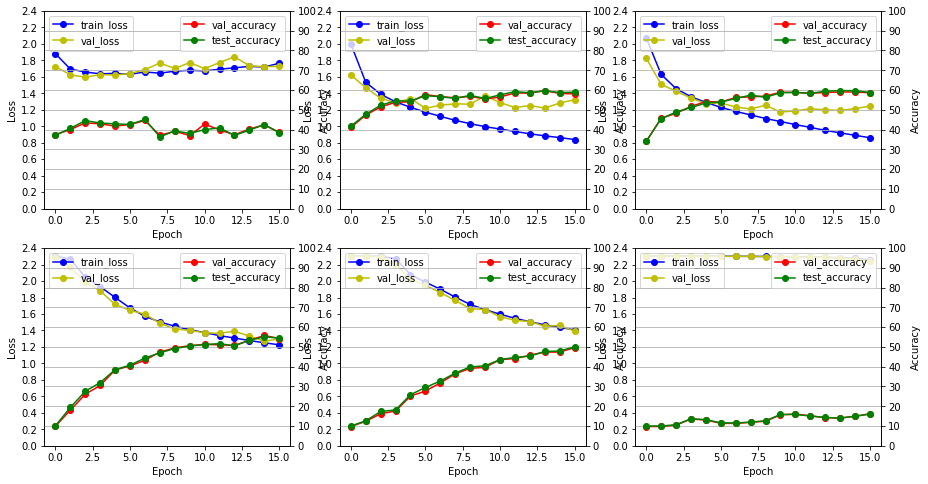

In [92]:
plot(train_loss_4, val_loss_4, val_acc_4, test_acc_4)

For bathc_size = 8

In [94]:
# allow a space to store the loss and accuracy of each epoch of each model

train_loss_8 = []
val_loss_8 = []
val_acc_8 = []
test_acc_8 = []

In [95]:
train_2(learning_rate, train_loss_8, val_loss_8, val_acc_8, test_acc_8)

learning_rate = 0.00500
1 epoch, train_loss: 1.859
1 epoch, val_loss: 1.608
Accuracy of the network on the 5000 validation images: 41 %
Accuracy of the network on the 10000 test images: 43 %
2 epoch, train_loss: 1.554
2 epoch, val_loss: 1.520
Accuracy of the network on the 5000 validation images: 45 %
Accuracy of the network on the 10000 test images: 45 %
3 epoch, train_loss: 1.445
3 epoch, val_loss: 1.479
Accuracy of the network on the 5000 validation images: 47 %
Accuracy of the network on the 10000 test images: 47 %
4 epoch, train_loss: 1.392
4 epoch, val_loss: 1.420
Accuracy of the network on the 5000 validation images: 49 %
Accuracy of the network on the 10000 test images: 49 %
5 epoch, train_loss: 1.343
5 epoch, val_loss: 1.556
Accuracy of the network on the 5000 validation images: 47 %
Accuracy of the network on the 10000 test images: 48 %
6 epoch, train_loss: 1.306
6 epoch, val_loss: 1.377
Accuracy of the network on the 5000 validation images: 52 %
Accuracy of the network on th

1 epoch, train_loss: 2.303
1 epoch, val_loss: 2.301
Accuracy of the network on the 5000 validation images: 10 %
Accuracy of the network on the 10000 test images: 9 %
2 epoch, train_loss: 2.298
2 epoch, val_loss: 2.291
Accuracy of the network on the 5000 validation images: 13 %
Accuracy of the network on the 10000 test images: 12 %
3 epoch, train_loss: 2.260
3 epoch, val_loss: 2.180
Accuracy of the network on the 5000 validation images: 15 %
Accuracy of the network on the 10000 test images: 15 %
4 epoch, train_loss: 2.089
4 epoch, val_loss: 2.015
Accuracy of the network on the 5000 validation images: 24 %
Accuracy of the network on the 10000 test images: 23 %
5 epoch, train_loss: 2.003
5 epoch, val_loss: 1.963
Accuracy of the network on the 5000 validation images: 26 %
Accuracy of the network on the 10000 test images: 26 %
6 epoch, train_loss: 1.949
6 epoch, val_loss: 1.907
Accuracy of the network on the 5000 validation images: 29 %
Accuracy of the network on the 10000 test images: 30 %

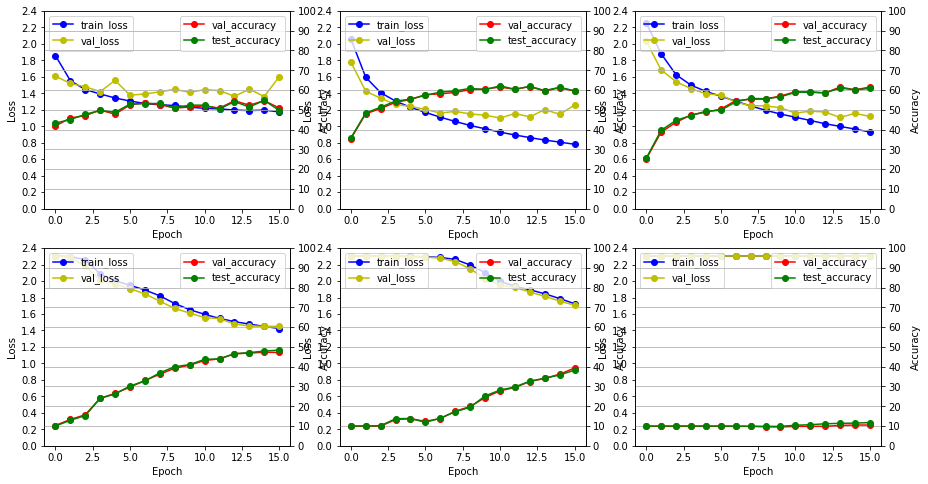

In [96]:
plot(train_loss_8, val_loss_8, val_acc_8, test_acc_8)

### your analysis comes here:
##### (my analysis about the choice of hyper-parameter is at the beginning of the part 2.)
-----
##### 1) What are the choices that could be empirically ignored without doing any experiments? 
#####     Were you correct after you conduct the experiments?
In term of learning rate, 0.005 can be empirically ignored because it is too large for training a network. 0.00005 and 0.00001 can be ignored too because they are too small.

In term of epoch, 2 can be ignored because two times of back propagation is not enough for training obviously. 1 can be ignored for the same reason. Meanwhile, 16 can be ignored too because that from the description of the dataset cifar-10, we can see that this dataset is relatively simple and 16 epochs maybe too much, leading over-fitting. 

In term of batch size, as I read some papers but I didn’t find exactly explaination about the choice of batch size. However, some developed and famous does not set their batch size as small as 2. So I prefer to ignore 2 if I must make a choice.

However, I still test all the hyper-parameters in aim of verifying whether my conjecture is correct.

##### 2) How many epochs are passed when the network is converged?
As shown in the figures, the notwork is converges after epoch 6-7, so I guess 8 is a good choice, making the model achieve a balance between under-fitting and over-fitting.

##### 3) Why too large or too small learning rates are not good choices?
The loss of a network can't converge due to a considerable lager learning rate, i.e. the loss raises up with training. Meanwhile, too small learning rate lead to an extremely low speed of decline of the loss and the network is easy to get stuck in a local optimal solution.

##### 4) What are the specification of the computer you are using?  E.g. the cpu/gpu type and the corresponding memory.
CPU: Intel Core i5-7200U-8G

GPU: NVIDIA GeForce 940MX-4G

##### 5) How long do you run an epoch? Did you use samples of the original dataset to speed up your progress  and how did it work?
Each epoch takes about 66 seonds On average.

##### 6)Are there any overfitting problems?
As shown in the figures, the notwork is converges at epoch 6-7, and over-fitting happens after 8 epochs.

##### 7)How to confirm if there is overfitting  problems?
When the loss value of train keeps going down but the loss value of validation remains the same or even raising up, we should be alert to the situation of overfitting.

##### 8)Is this model enough for  classification of cifar-10?
Actually, the accuracy of test datasets is only 60% highest, so this is only an acceptable model. It can be improved a lot.

### Part 3: More options

Please indicate the three tasks you are assigned here:

1) Transformation: Affine + Resize (size, angle)

2) Structure: Pooling method (MaxPool / AvgPool)

3) Training procedure: SGD setting (momentum)

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

For Transformation

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

My baseline is a 3conv + 3pooling + 3fc + 1out network, Modified is the modified network using your own assigned task.

##### your analysis comes here:
-----
##### 1) How do I define my new baseline?
The old baseline contains 3 conv + 3 pooling + 3 fc + 1 out. So I just add a con layer and a pooling layer to the old one. Besides, because I resize the input to 45 and add a conv laeyr, so I change the number of connection of the last conv layer and first fc layer.

##### 2) Why do I define my baseline in this way?
Becasue I just want to create the simplest baseline and modified it later so I just add a conv layer and a pooling layer, and adjust the size of the conv kernel because the outputn size of the last conv is too small if remain the conv kernel size as 5 * 5. Finally, I adjust the he number of connection of the last conv layer and first fc layer to make it work.

##### 3) What is the different between my baseline and the previou one?
1.The new baseline contain 3 conv layer + 3 pooling layer while the old one only contain 2 conv layer + 2 pooling layer.

2.The output size of the last pooling layer is different: 16 * 3 * 3 for the new one while 16 * 5 * 5 for the old one.

3.The conv kernel is 3 * 3 in the new one while it is 5 * 5 in the old one.
_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

##### your analysis comes here:
-----
I test my three tasks in different methods(i choose the best choice of hyper-parameter from my part 2):

###### 1) Resize + Affine
   
In this part I choose 2 different resize parameter: 16 and 48. The size 16 means I resize the picture to a smaller size while 48 means zooming in. In term of affine, I choose three hyper-parameters: 30, 45, 60. Controlling variables and making combinations of two set of hyper-parameters, I got 6 sets of model.

As shown in fig.1, there is no problems of over-fitting. The performance of 'resize 16' is poorer on average. The accuracy is about 50%. While 'resize 48' get a better performance. In the compare of the information of this set, we can see 'resize 48 + Affine 30' is the best with the accuracy 60% approximately.

I looked at some information about 'resize'. 'Resize' is mostly used to modify the size of the input image to a certain standard when the size of input image is different. I didn't find out about using resize for image argument, but according to my experiments, resizing to a smaller size lead to a worse result at least for the cifar-10 dataset.

'Affine' doesn't give a significant improvement on this dataset, and it works best when the rotation angle is 30, so I guess the best performance achieves when do not implement 'affine'.

###### 2) Pooling

In this part I choose 2 hyper-parameters of pooling: the method of pooling and the size of pooling kernel. In general, max pooling and average pooling have a very similar performance while kernel size 2 has an obviously better performance than 3. I prefer to choose max pooling with the kernel size of 2 as my final network.

The feature map losts too many information due to a big size of pooling kernel size, especially for the picture as small as cifar-10.

###### 3) SGD
I test the momentum of SGD optimizer, setting it as 0.6, 0.7, 0.8, 0.85, 0.9, 0.95 seperately. As shown in the fig.3, the network has the best performance when momentun is 0.9.

Momentum is a method that accelerates SGD and dampens oscillations by adding a fraction γ of the update vector of the previous time step to the next update vector. The equation is shown in fig.4.

I find a very interesting and vivid explanation of momentum: a ball accumulates momentum as it rolls down a scope, becoming faster and faster on the way. Momentum do the same thing to our parameter updates: The momentum increases in the same directions with gradients and reduces updates for dimensions whose gradients change directions, leading to a faster convergence and oscillation reduction.

However there is no scientific inference that why 0.9 achieve the best performance, although it is a really reasonable value.
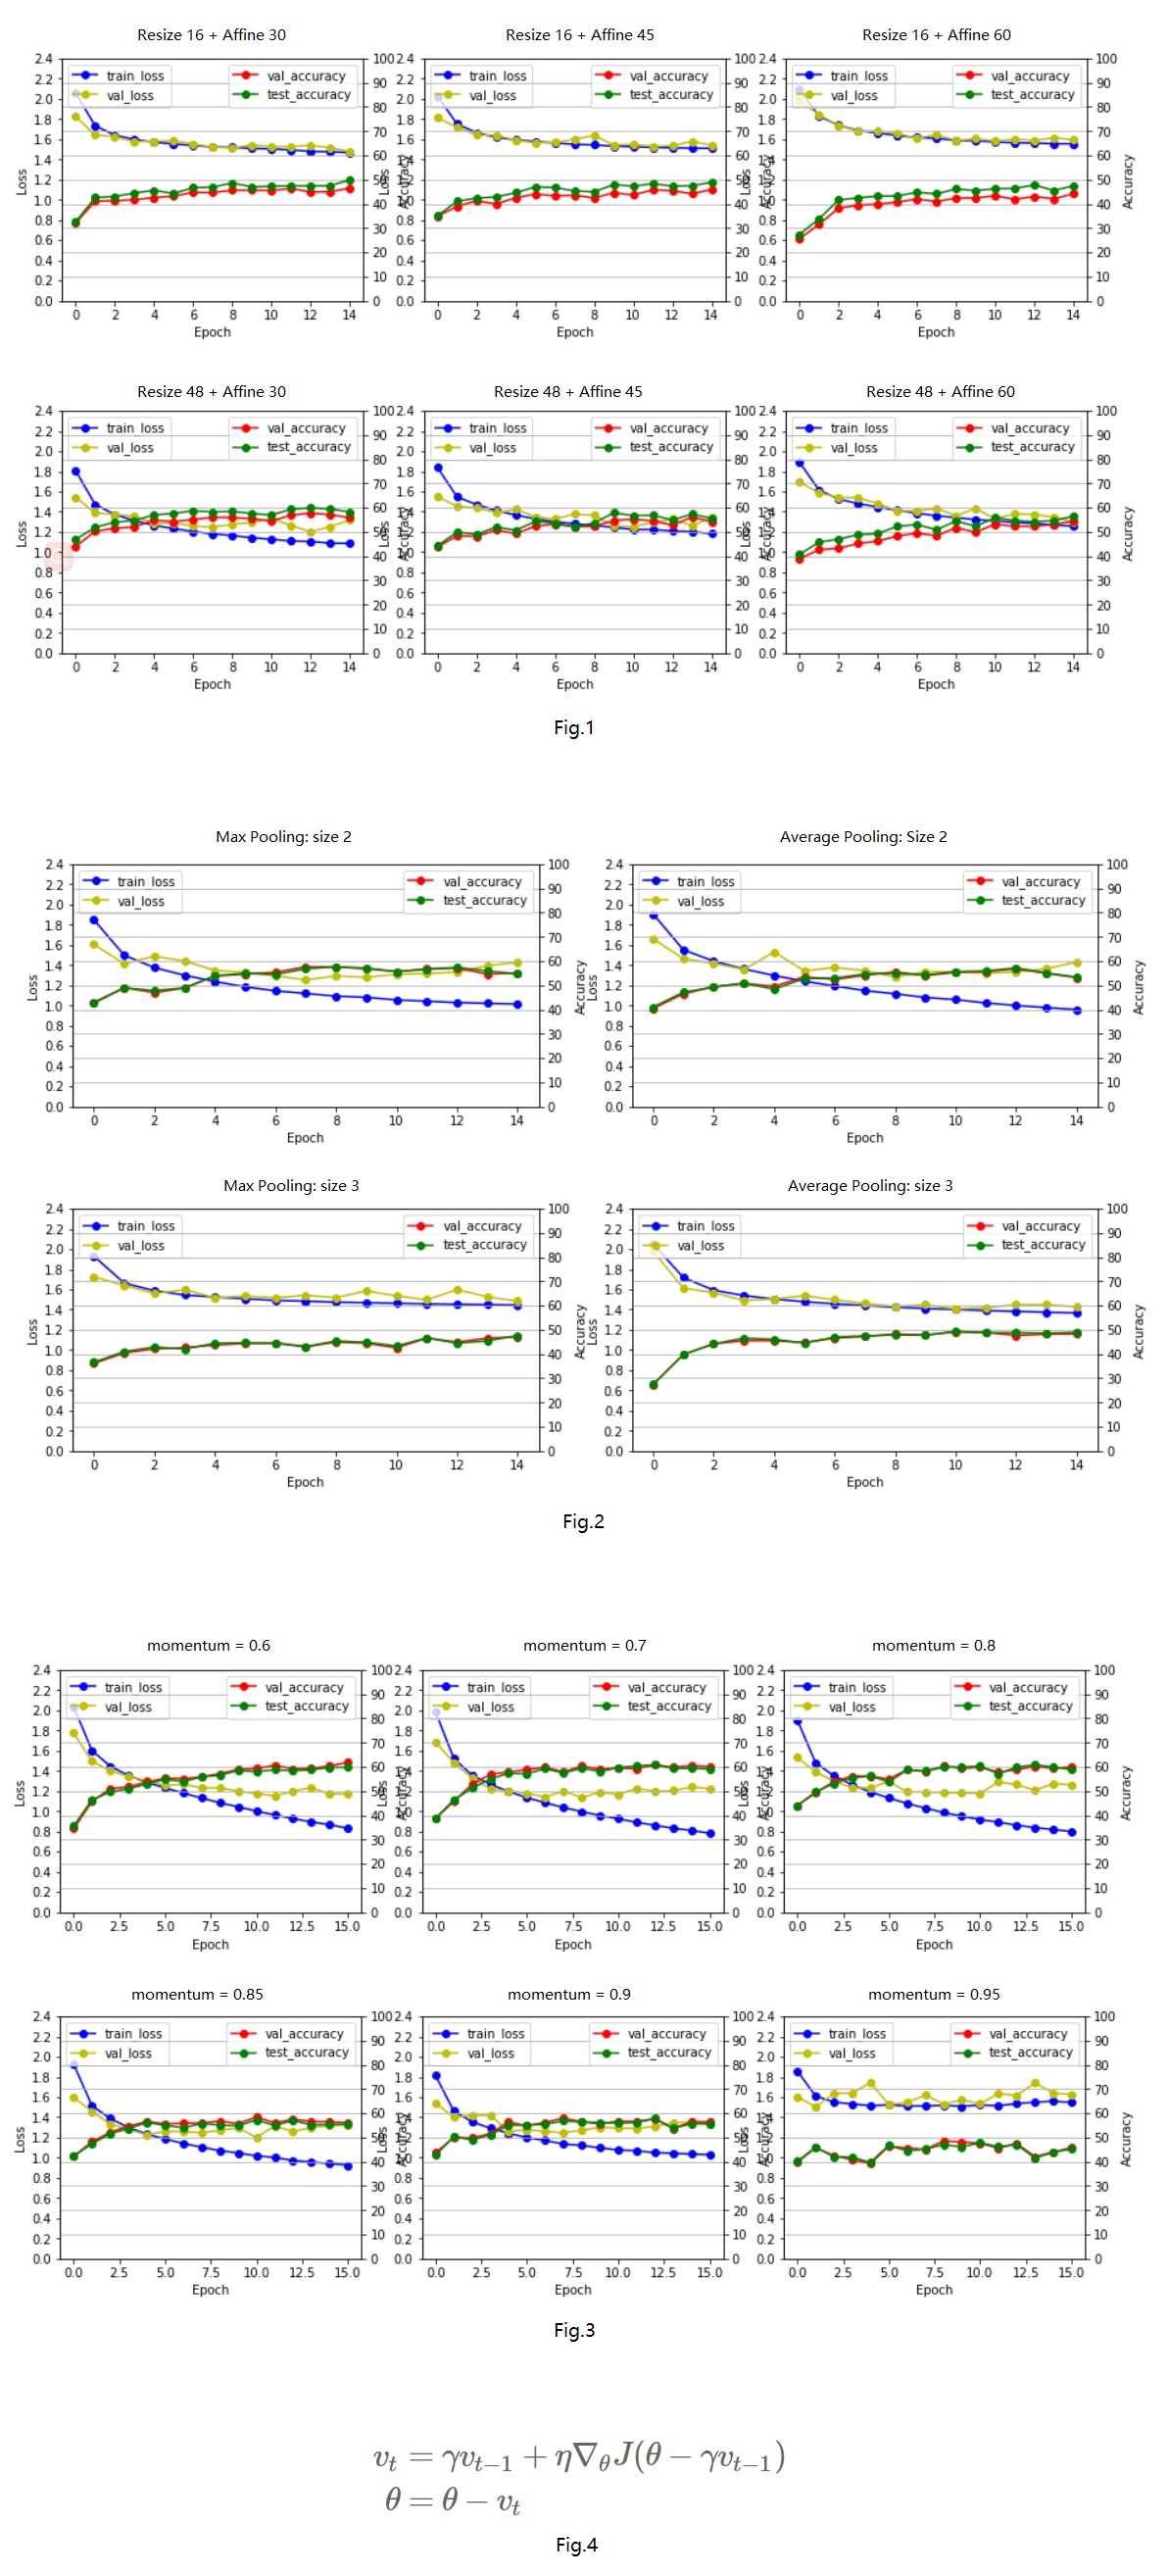
_____

### Reference
1. PyTorch documentation, https://pytorch.org/docs/stable/nn.html
2. Danieljf24, Summary of Pooling Method， https://blog.csdn.net/danieljianfeng/article/details/42433475
3. Sebastian Ruder, An overview of gradient descent optimization algorihms, https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d
4. Vitaly Bushaev, Stochastic Gradient Descent with momentumt, http://ruder.io/optimizing-gradient-descent/

### Specs:
e.g. Your cpu version or GPU version, the memory size of your computer. Your software versions.

In [ ]:
##################################
###  CPU: Intel Core i5-7200U  ###
###  Memory size: 8G           ###         
###  Version: V1.0             ###
###  Author: Shuang            ###
##################################